# LSTM recipe generator training

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the recipe dataset.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Import modules and set random seeds.

In [2]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print(f'Vocabulary size: {VOCAB_SIZE}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocabulary size: 30522


Download the recipe dataset and extract directions texts.

In [4]:
from datasets import load_dataset
recipe = load_dataset('Shengtao/recipe')

def join_title_and_directions(title_directions):
    title, directions = title_directions
    return f'Recipe for {title}: {directions}'

recipe_texts = zip(recipe['train']['title'], recipe['train']['directions'])
recipe_texts = [*map(join_title_and_directions, recipe_texts)]
recipe_texts = recipe_texts[::4] # Select 25% of the entire training set.

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

recipe.csv:   0%|          | 0.00/64.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/32722 [00:00<?, ? examples/s]

In [5]:
recipe_texts[0]

'Recipe for Simple Macaroni and Cheese: Bring a large pot of lightly salted water to a boil. Cook elbow macaroni in the boiling water, stirring occasionally until cooked through but firm to the bite, 8 minutes. Drain. Melt butter in a saucepan over medium heat; stir in flour, salt, and pepper until smooth, about 5 minutes. Slowly pour milk into butter-flour mixture while continuously stirring until mixture is smooth and bubbling, about 5 minutes. Add Cheddar cheese to milk mixture and stir until cheese is melted, 2 to 4 minutes. Fold macaroni into cheese sauce until coated.'

Check the distribuion of the token length.

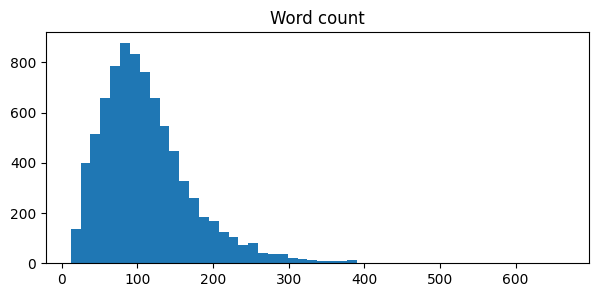

In [6]:
fig = plt.figure(figsize=(7, 3))
subplot = fig.add_subplot(1,1,1)
subplot.set_title('Word count')

_ = subplot.hist([*map(lambda x: len(x.split(' ')), recipe_texts)], bins=50)

Create the training and test datasets, truncating long texts into 128 words.

In [7]:
MAX_LEN = 128
train_set, test_set = train_test_split(recipe_texts, test_size=0.1)

train_set = tokenizer(train_set, max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])[:, :-1]
train_label = np.array(train_set['input_ids'])[:, 1:]

test_set = tokenizer(test_set, max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])[:, :-1]
test_label = np.array(test_set['input_ids'])[:, 1:]

Define the LSTM model.

In [8]:
lstm_model = models.Sequential(name='LSTM_next_word_predictor')
lstm_model.add(layers.Input(shape=(None,), name='input_ids'))
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, name='text_embedding'))
lstm_model.add(layers.LSTM(512, return_sequences=True, name='LSTM'))
lstm_model.add(layers.Dense(VOCAB_SIZE, activation='softmax', name='softmax'))

lstm_model.summary()

Model: "LSTM_next_word_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_embedding (Embedding)           │ (None, None, 512)           │      15,627,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM (LSTM)                          │ (None, None, 512)           │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, None, 30522)         │      15,657,786 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,384,250 (127.35 MB)

 Trainable params: 33,384,250 (127.35 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and the sparse categorical crossentroy as a loss function.

In [9]:
lstm_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

Train the model.

In [10]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=8, epochs=10)

Epoch 1/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 101s 106ms/step - acc: 0.2398 - loss: 4.9316 - val_acc: 0.5058 - val_loss: 2.6034
Epoch 2/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 141s 107ms/step - acc: 0.5280 - loss: 2.4392 - val_acc: 0.5611 - val_loss: 2.1840
Epoch 3/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 143s 108ms/step - acc: 0.5734 - loss: 2.0739 - val_acc: 0.5811 - val_loss: 2.0352
Epoch 4/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 99s 107ms/step - acc: 0.5948 - loss: 1.9006 - val_acc: 0.5924 - val_loss: 1.9567
Epoch 5/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 143s 108ms/step - acc: 0.6091 - loss: 1.7844 - val_acc: 0.5982 - val_loss: 1.9149
Epoch 6/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 141s 107ms/step - acc: 0.6204 - loss: 1.6950 - val_acc: 0.6024 - val_loss: 1.8911
Epoch 7/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - acc: 0.6306 - loss: 1.6204 - val_acc: 0.6049 - val_loss: 1.8791
Epoch 8/10
921/921 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - acc: 0.6397 - loss: 1.5565 - val_acc: 0.6060 - val_loss: 1.8740
Epoch 9/10
921/921 ━━━━━━

Mount the google drive and save the trained model.

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

model_file = '/content/gdrive/My Drive/LSTM_recipe_generator.keras'
lstm_model.save(model_file)
!ls -lh "{model_file}"

Mounted at /content/gdrive
-rw------- 1 root root 383M Jan 29 07:55 '/content/gdrive/My Drive/LSTM_recipe_generator.keras'
